In [1]:
from chiborg import jk_data, jk_hyp, jk_calc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import cholesky
import copy

### Make many realizations of a $N = 2$ data set where one datum is unbiased (true mean = 1) and the other is biased by a vlue of 5. Set error bars equal to 1 and 2. Make a histogram and print sample covariance.

Sample covariance of data is 
 [[9.99172872e-01 1.08348367e-03]
 [1.08348367e-03 4.00717173e+00]]


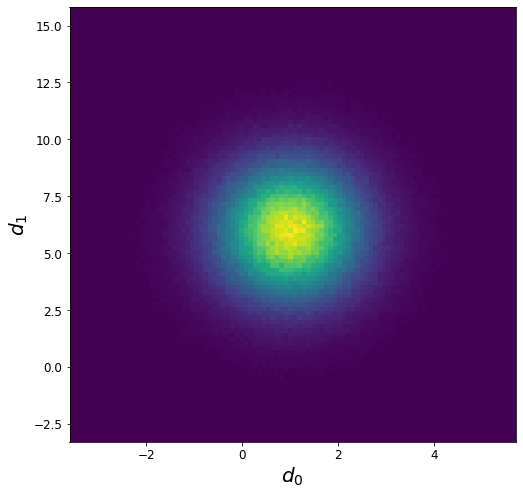

In [2]:
np.random.seed(47)
num_draw = int(1e6)

jkd = jk_data(sim_mean=np.ones(2), noise_cov=np.diag([1, 4]), sim_bias=np.array([0, 5]), num_dat=2,
              num_draw=num_draw)

def dat_hist_2d(jkd):

    plt.figure(figsize=(8, 8))

    _, _, _, _ = plt.hist2d(*jkd.data_draws.T, bins=100)
    plt.xlabel("$d_0$", fontsize=20)
    plt.ylabel("$d_1$", fontsize=20)
    plt.tick_params(labelsize=12)

dat_hist_2d(jkd)
print(f"Sample covariance of data is \n {np.cov(jkd.data_draws.T)}")

### Make a similar data set, but make the bias for the second data point a random gaussian draw, simulating the marginal distribution over a bias prior corresponding to the gaussian draws. This will slightly broaden the biased dimension compared to the previous example ($d_1$).

Sample covariance of data is 
 [[ 9.97808166e-01 -2.56509299e-03]
 [-2.56509299e-03  5.00008498e+00]]


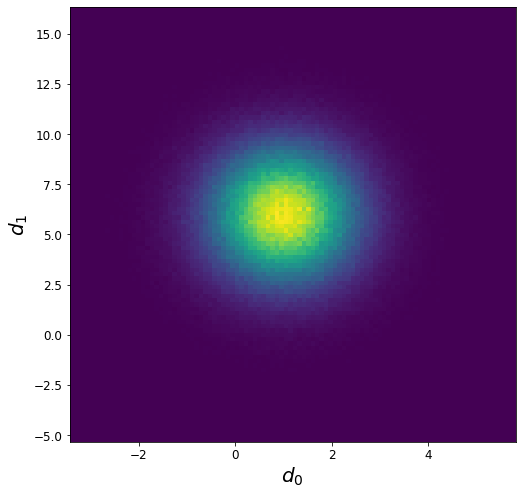

In [3]:
gauss_bias = np.random.multivariate_normal(mean=[0, 5], cov=[[0,0],[0, 1]], size=int(1e6))
jkd = jk_data(sim_mean=np.ones(2), noise_cov=np.diag([1,4]), sim_bias=gauss_bias, num_dat=2, num_draw=num_draw)

dat_hist_2d(jkd)
print(f"Sample covariance of data is \n {np.cov(jkd.data_draws.T)}")

### Put all these realizations through the "diagonal hypothesis" set and analyze the performance. This begins by making a "jk_hyp" object, which contains all the information about the hypothesis sets, such as the prior parameters, number of hypotheses, etc. We then hand it to a "jk_calc" object to do all the probability calculations. We will look for $5\sigma$ biases.

In [4]:
jkh = jk_hyp(jkd, 5 * np.array([1, 2]), np.ones(2))
print(jkh.bias_prior.mean)
print(jkh.bias_prior.cov)

[[ 0.  0.]
 [ 5.  0.]
 [ 0. 10.]
 [ 5. 10.]]
[[[0. 0.]
  [0. 0.]]

 [[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


#### This is a fairly strong bias compared to the error bar on the dimension it exists in, so it should be highly identifiable on average.

In [5]:
jkc = jk_calc(jkd, jkh)

In [6]:
print(jkc.post.shape)

(4, 1000000)


In [13]:
H = np.sum(-np.log2(jkc.post) * jkc.post, axis=0)

(array([34526., 34108., 29303., 26239., 23208., 21214., 19850., 18262.,
        17106., 16337., 15630., 14798., 14032., 13425., 12889., 12464.,
        12272., 11740., 11464., 11129., 10861., 10693., 10391., 10192.,
        10108.,  9951.,  9729.,  9445.,  9305.,  9119.,  9128.,  8961.,
         8884.,  9037.,  8779.,  8689.,  8725.,  8651.,  8686.,  8619.,
         8429.,  8494.,  8558.,  8381.,  8592.,  8612.,  8648.,  8651.,
         8755.,  8693.,  8844.,  8727.,  9147.,  9070.,  9300.,  9635.,
         9795., 10165., 10735., 11034., 11639., 12732., 14382., 19068.,
        18564., 12594., 10176.,  8564.,  7581.,  6840.,  6268.,  5742.,
         5527.,  5043.,  4779.,  4563.,  4229.,  4073.,  3787.,  3744.,
         3547.,  3264.,  3103.,  3077.,  2976.,  2930.,  2798.,  2707.,
         2583.,  2497.,  2413.,  2340.,  2339.,  2160.,  2180.,  2153.,
         2052.,  2016.,  1870.,  1869.,  1753.,  1796.,  1741.,  1685.,
         1660.,  1609.,  1608.,  1532.,  1578.,  1508.,  1458., 

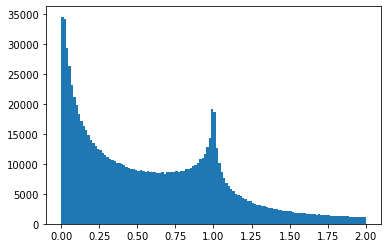

In [14]:
plt.hist(H, bins="auto")